In [1]:
import numpy as np
import torch
import torchvision

from models.i3d.i3d_src.i3d_net import I3D
from models.raft.extract_raft import DATASET_to_RAFT_CKPT_PATHS
from models.raft.raft_src.raft import RAFT, InputPadder

from models.transforms import (Clamp, PermuteAndUnsqueeze, PILToTensor,
                               ResizeImproved, ScaleTo1_1, TensorCenterCrop,
                               ToFloat, ToUInt8)

from utils.utils import dp_state_to_normal

import cv2



In [2]:
class CustomModel(torch.nn.Module):
    def __init__(self, I3D_weight_path, RAFT_weight_path, img_stack_size, device='cuda'):
        super().__init__()

        self.device = device
        self.padder = None
        self.stack_size = img_stack_size

        # self.i3d_model_rgb = I3D(num_classes=400, modality='rgb')
        # self.i3d_model_rgb.load_state_dict(torch.load(I3D_weight_path['rgb'], map_location='cpu'))
        # self.i3d_model_rgb = self.i3d_model_rgb.to(self.device).eval()

        # self.i3d_model_flow = I3D(num_classes=400, modality='flow')
        # self.i3d_model_flow.load_state_dict(torch.load(I3D_weight_path['flow'], map_location='cpu'))
        # self.i3d_model_flow = self.i3d_model_flow.to(self.device).eval()

        self.raft_model = RAFT()
        state_dict = dp_state_to_normal(torch.load(RAFT_weight_path, map_location='cpu'))
        self.raft_model.load_state_dict(state_dict)
        self.raft_model = self.raft_model.to(self.device).eval()

    def forward(self, x):
        rgb_stack = torch.cat(x).to(self.device)
        stream_slice = self.raft_model(self.padder.pad(rgb_stack)[:-1], self.padder.pad(rgb_stack)[1:])

        return stream_slice


In [3]:
video_path = "./videos/normal.mp4"

cap = cv2.VideoCapture(video_path)

I3D_weight_path = {"rgb" : "./models/i3d/checkpoints/i3d_rgb.pt",
                    "flow" : "./models/i3d/checkpoints/i3d_flow.pt"}

RAFT_weight_path = "./models/raft/checkpoints/raft-sintel.pth"

min_side_size = 256

resize_transforms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                                    ResizeImproved(min_side_size),
                                                    PILToTensor(),
                                                    ToFloat(),])

rgb_stack = []
stack_size = 60

model = CustomModel(I3D_weight_path, RAFT_weight_path, img_stack_size = stack_size, rgb_shape_size=(1280,720,3))

first_frame = True
while cap.isOpened():
    frame_exists, rgb = cap.read()

    if first_frame:
        first_frame = False
        if frame_exists is False:
            continue

    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    rgb = resize_transforms(rgb)
    rgb = rgb.unsqueeze(0)

    rgb_stack.append(rgb)

    if len(rgb_stack) - 1 == stack_size:
        result = model(rgb_stack)
        print(result.shape)

OutOfMemoryError: CUDA out of memory. Tried to allocate 864.00 MiB (GPU 0; 7.78 GiB total capacity; 5.63 GiB already allocated; 241.69 MiB free; 5.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

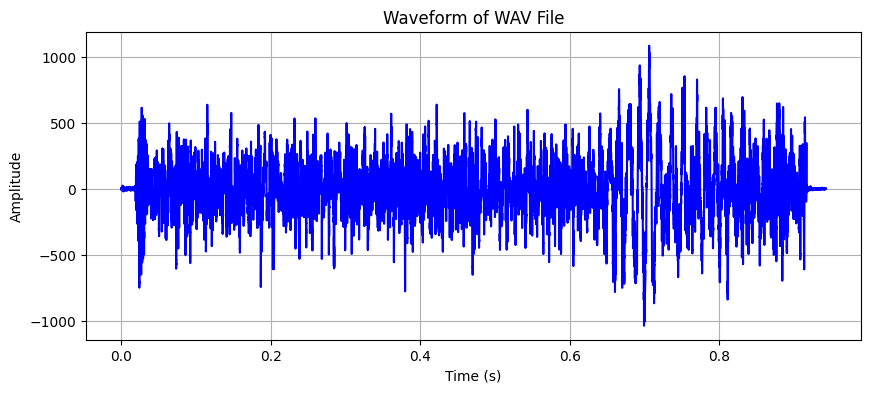

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import wave

# WAV 파일 경로 설정
wav_file = "./dataset/train/audios/test.wav"

# WAV 파일 열기
with wave.open(wav_file, "rb") as wav:
    # WAV 파일의 오디오 데이터 읽기
    frames = wav.readframes(-1)
    samples = np.frombuffer(frames, dtype="int16")

    # WAV 파일의 샘플 레이트와 채널 수 가져오기
    sample_rate = wav.getframerate()
    num_channels = wav.getnchannels()

# 오디오 데이터의 시간 배열 생성
duration = len(samples) / sample_rate
time = np.linspace(0., duration, len(samples))

# 그래프 그리기
plt.figure(figsize=(10, 4))
plt.plot(time, samples, color="b")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of WAV File")
plt.grid(True)
plt.show()

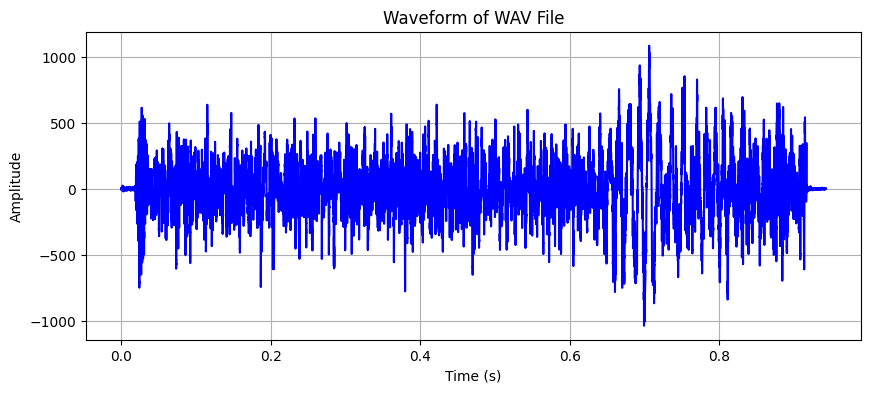

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import wave

# WAV 파일 경로 설정
wav_file = "./dataset/train/audios/normal_0.wav"

# WAV 파일 열기
with wave.open(wav_file, "rb") as wav:
    # WAV 파일의 오디오 데이터 읽기
    frames = wav.readframes(-1)
    samples = np.frombuffer(frames, dtype="int16")

    # WAV 파일의 샘플 레이트와 채널 수 가져오기
    sample_rate = wav.getframerate()
    num_channels = wav.getnchannels()

# 오디오 데이터의 시간 배열 생성
duration = len(samples) / sample_rate
time = np.linspace(0., duration, len(samples))

# 그래프 그리기
plt.figure(figsize=(10, 4))
plt.plot(time, samples, color="b")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of WAV File")
plt.grid(True)
plt.show()

In [23]:
from dataloader_custom import AC_Data_Loader
from torch.utils.data import TensorDataset, DataLoader
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU Use : ',torch.cuda.is_available())

data_path_x = "./dataset/train/features/"
data_loader = AC_Data_Loader(data_path_x)

train_loader = DataLoader(dataset = data_loader, batch_size=1, shuffle=True)


GPU Use :  True


In [24]:
for i, (x_data, y_data) in enumerate(train_loader):
    print(i)
    print(x_data.shape)
    print(y_data)


0
torch.Size([1, 1, 2176])
tensor([0])
1
torch.Size([1, 1, 2176])
tensor([0])
2
torch.Size([1, 1, 2176])
tensor([0])
3
torch.Size([1, 1, 2176])
tensor([0])


In [20]:
data_loader.label_data[0]

0